# Regression
### Linear Regression VS Bayesian Regression VS Gaussian Process Regression

Let's start by explaining different types of linear regression. In simple linear regression, we first make a linearity assumption about the data (we assume the target variable is a linear combination of the features), then we estimate model parameters based on the data. In Bayesian linear regression, we make the same linearity assumption, however we take it a step further and make an incorporate beliefs about the parameters into the model (priors), then learn the parameters from the data. Gaussian Process Regression takes a different approach. We don't drop the linearity assumption, and the priors on the parameters. Instead we put a prior on **_all possible models_**. As we observe data, the posterior

Intuitively, "fitting" a Gaussian Process means eliminating all functions which dont pass through the observed data points.

## GPR vs Bayesian Linear Regression vs Linear Regression

### Simulate Data

In [1]:
from scipy.stats import norm
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression

%config InlineBackend.figure_format = 'retina'

In [2]:
# y = f(x) + e
coef = 2
intercept = 1
def f (x, coef=coef, intercept=intercept) :
    return coef*x + intercept

n = 20
mass = np.linspace(5, 15, n) + norm.rvs(scale=3, size = n)
f = f(mass)
force = f + norm.rvs(scale = 5, size = n)

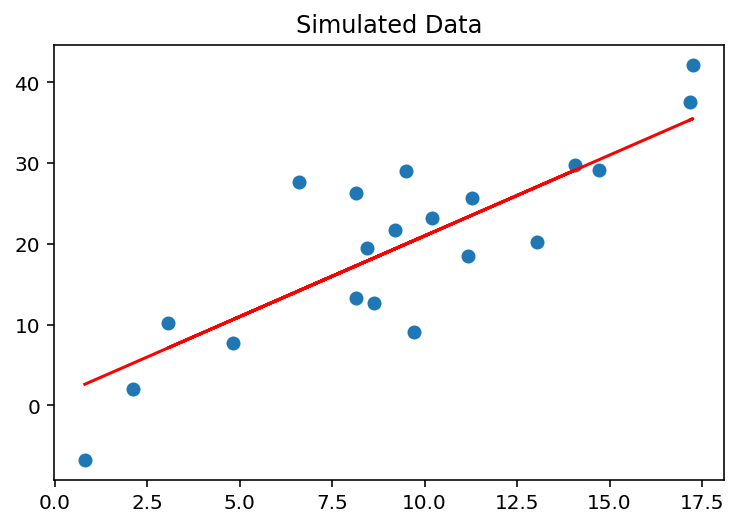

In [3]:
fig, ax = plt.subplots(1, 1)
_ = ax.scatter(mass, force)
_ = ax.plot(mass, f, color="red")
_ = plt.title("Simulated Data")

### Linear Regression

In simple linear regression, we first assume that the features and response are linearly related. Then use the data to estimate our parameters. 

In [4]:
reg = LinearRegression()
_ = reg.fit(mass.reshape(-1, 1), force)

print("Coefficient: %f" % reg.coef_)
print("Intercept: %f" % reg.intercept_)
print("Coefficient of Determination: %f" % reg.score(mass.reshape(-1, 1), force))

Coefficient: 2.231842
Intercept: -1.058636
Coefficient of Determination: 0.722867


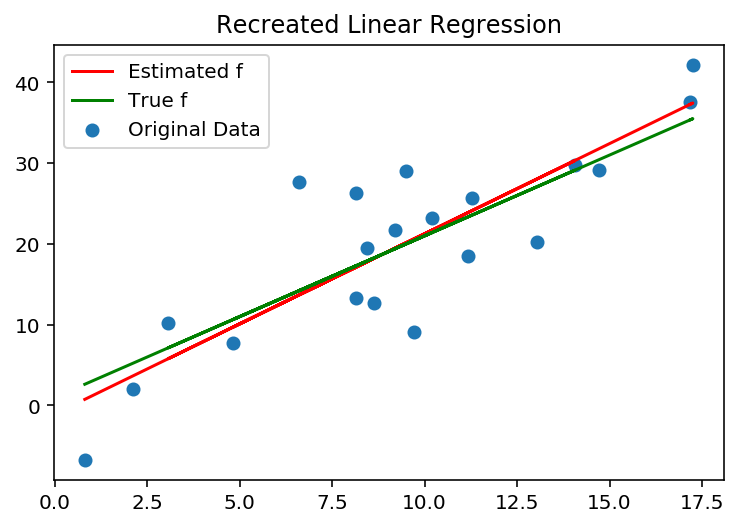

In [5]:
pred = reg.predict(mass.reshape(-1, 1))
f_ = mass * reg.coef_[0] + reg.intercept_

fig, ax = plt.subplots(1, 1)
_ = ax.scatter(mass, force, label = "Original Data")
_ = ax.plot(mass, f_, color = "red", label = "Estimated f")
_ = ax.plot(mass, f, color = "green", label = "True f")
_ = plt.title("Recreated Linear Regression")
_ = plt.legend()

# Bayesian Regression

In Bayesian regression, the aim is to quantify uncertainty in our model for different values of our parameters. We do this by learning distributions of the parameters instead of point estimates. 
We start by specifying priors for the parameters, and a likelihood for the data

$posterior \propto priors * likelihood$

# Testing Frameworks

In [25]:
DATA_URL = "https://d2hg8soec8ck9v.cloudfront.net/datasets/rugged_data.csv"
data = pd.read_csv(DATA_URL, encoding="ISO-8859-1")
df = data[["cont_africa", "rugged", "rgdppc_2000"]]
df = df[np.isfinite(df.rgdppc_2000)]
df["rgdppc_2000"] = np.log(df["rgdppc_2000"])

# Dataset: Add a feature to capture the interaction between "cont_africa" and "rugged"
df["cont_africa_x_rugged"] = df["cont_africa"] * df["rugged"]
df.head()
data = torch.tensor(df[["cont_africa", "rugged", "cont_africa_x_rugged", "rgdppc_2000"]].values, dtype=torch.float)

x_data, y_data = data[:, :-1], data[:, -1] #last column is the response

,cont_africa,rugged,rgdppc_2000,cont_africa_x_rugged
2,1,0.858,7.492609,0.858
4,0,3.427,8.216929,0.000
7,0,0.769,9.933263,0.000
8,0,0.775,9.407032,0.000
9,0,2.688,7.792343,0.000


## Bayesian Regression with Pyro

We would like to explore the relationship between topographic heterogeneity of a nation as measured by the Terrain Ruggedness Index (variable `rugged` in the dataset) and its GDP per capita. Terrain ruggedness or bad geography is related to poorer economic performance outside of Africa, but rugged terrains have had a reverse effect on income for African nations. Let us look at the data and investigate this relationship. We will be focusing on three features from the dataset: 
- `rugged`: quantifies the Terrain Ruggedness Index 
- `cont_africa`: whether the given nation is in Africa 
- `rgdppc_2000`: Real GDP per capita for the year 2000

In [26]:
#hide
import os
from functools import partial
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pyro
import pyro.distributions as dist

# Set matplotlib settings
%matplotlib inline
plt.style.use('default')

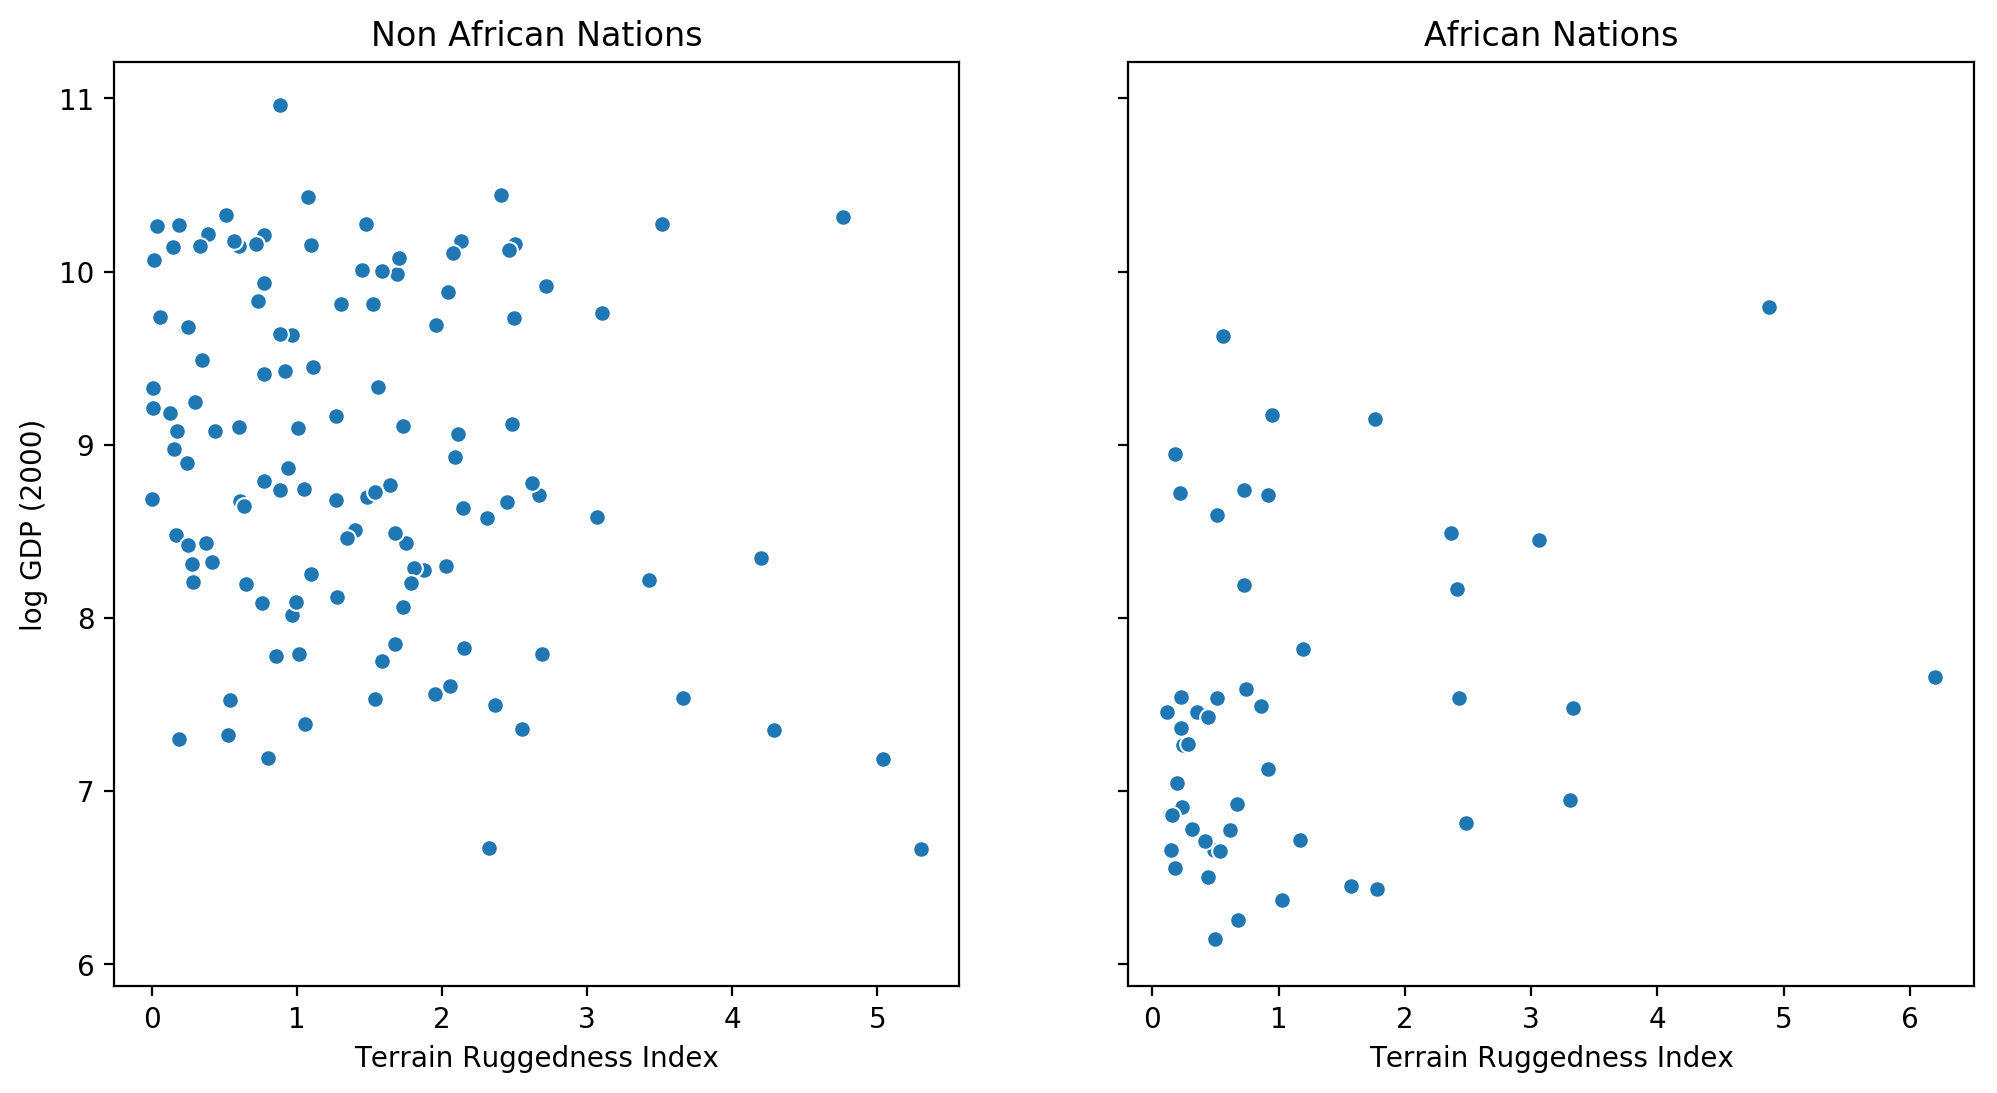

In [4]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
african_nations = df[df["cont_africa"] == 1]
non_african_nations = df[df["cont_africa"] == 0]
sns.scatterplot(non_african_nations["rugged"],
            non_african_nations["rgdppc_2000"],
            ax=ax[0])
ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="Non African Nations")
sns.scatterplot(african_nations["rugged"],
                african_nations["rgdppc_2000"],
                ax=ax[1])
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="African Nations");

In [5]:
from torch import nn
from pyro.nn import PyroModule

assert issubclass(PyroModule[nn.Linear], nn.Linear)
assert issubclass(PyroModule[nn.Linear], PyroModule)

In [7]:
# Regression model
linear_reg_model = PyroModule[nn.Linear](in_features = 3, out_features = 1)

# Define loss and optimization functions
loss_fn = torch.nn.MSELoss(reduction='sum') # MSE loss
optim = torch.optim.Adam(linear_reg_model.parameters(), lr=0.05) # Adam optimizer
num_iterations = 1000

In [8]:
def train():
    # run the model forward on the data
    y_pred = linear_reg_model(x_data).squeeze(-1)
    # calculate the mse loss
    loss = loss_fn(y_pred, y_data)
    # initialize gradients to zero
    optim.zero_grad()
    # backpropagate
    loss.backward()
    # take a gradient step
    optim.step()
    return loss

In [9]:
for i in range(num_iterations) :
    loss = train()
    if (i + 1) % 100 == 0 :
        print("[iteration %04d] loss: %.4f" % (i + 1, loss.item()))

[iteration 0100] loss: 1616.1372
[iteration 0200] loss: 833.7545
[iteration 0300] loss: 488.2652
[iteration 0400] loss: 296.0484
[iteration 0500] loss: 203.9386
[iteration 0600] loss: 166.3494
[iteration 0700] loss: 153.1786
[iteration 0800] loss: 149.2020
[iteration 0900] loss: 148.1668
[iteration 1000] loss: 147.9347


In [10]:
# Inspect learned parameters
print("Learned parameters:")
for name, param in linear_reg_model.named_parameters():
    print(name, param.data.numpy())

Learned parameters:
weight [[-1.9056364  -0.18700726  0.3726741 ]]
bias [9.190689]


### Plot Regression Fit

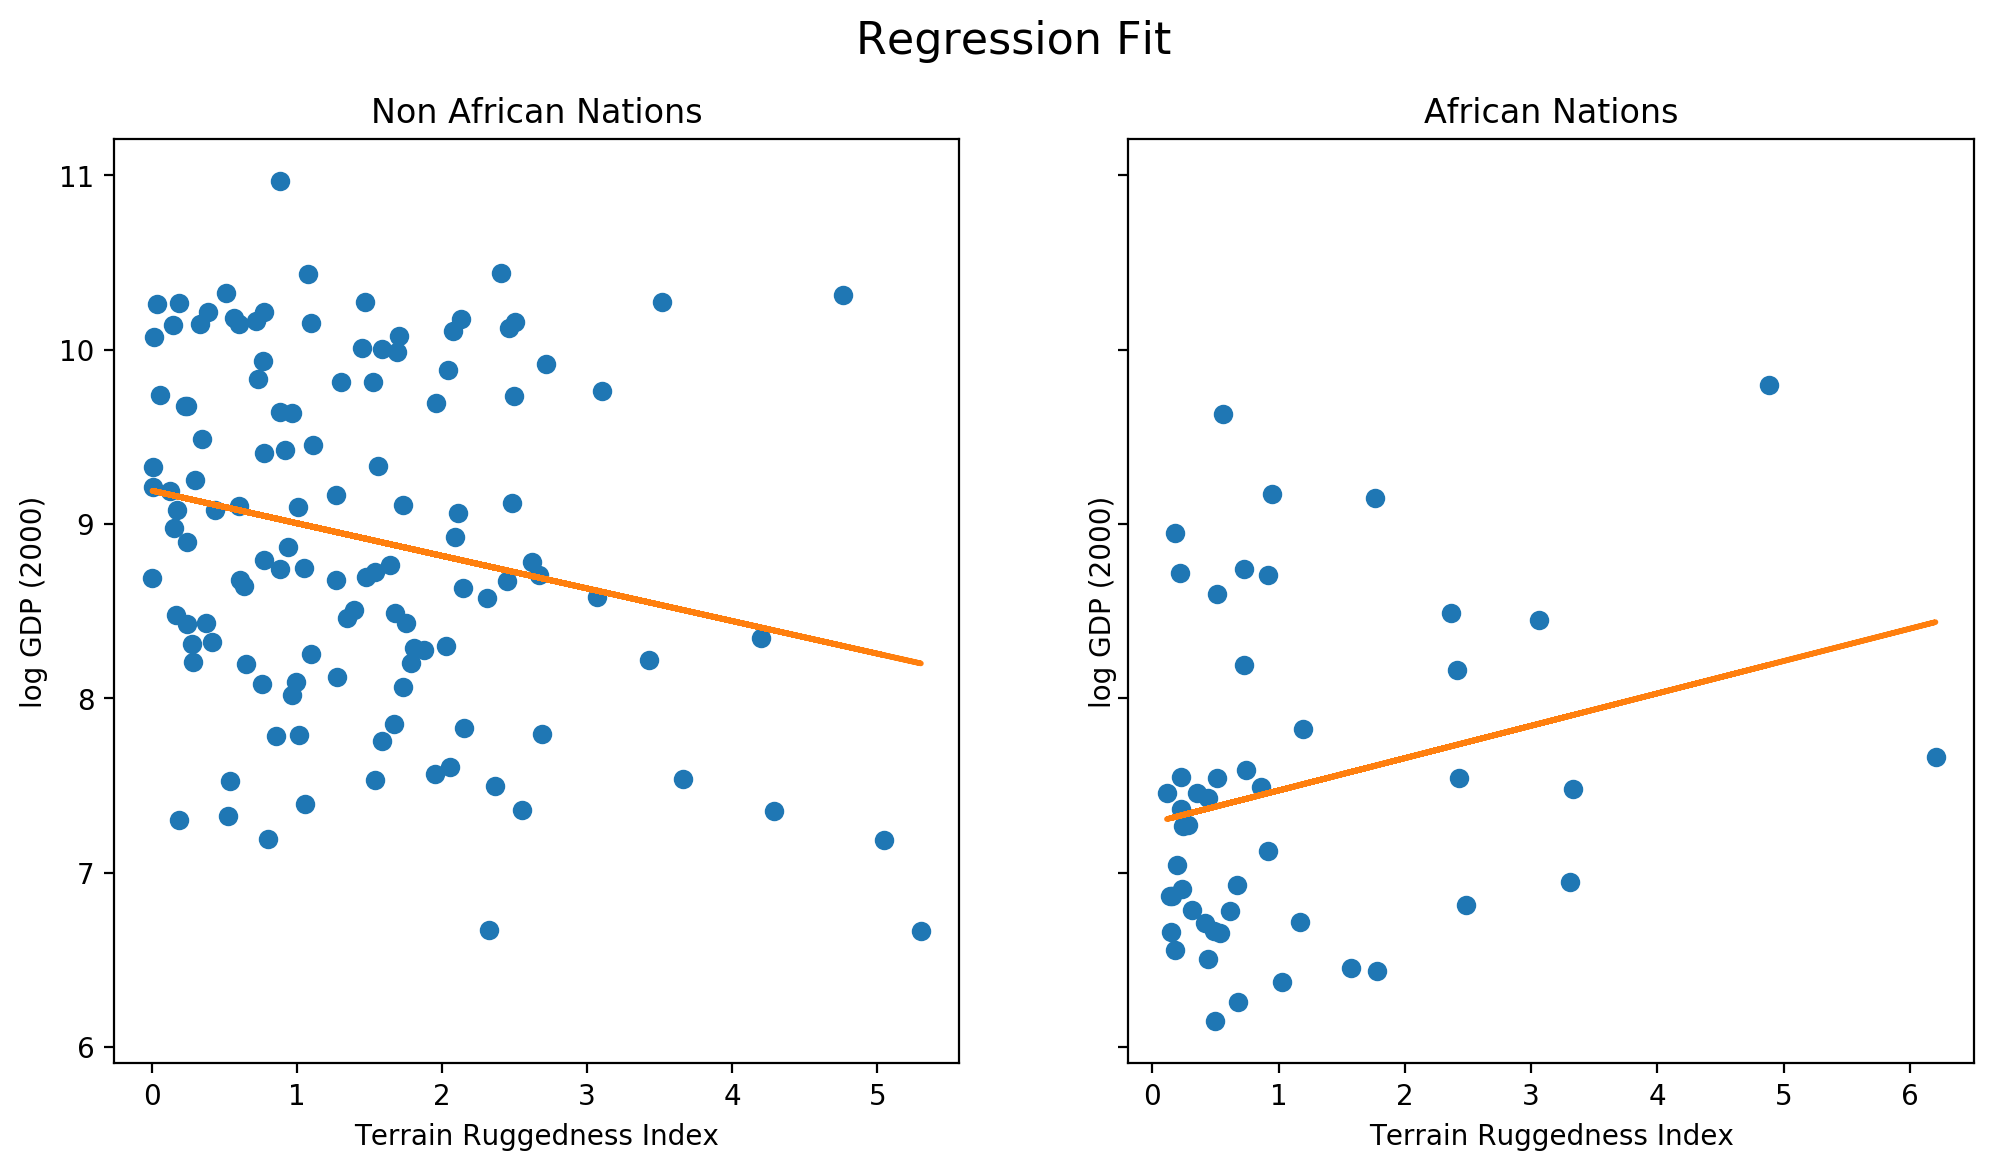

In [11]:
fit = df.copy()
fit["mean"] = linear_reg_model(x_data).detach().cpu().numpy()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
african_nations = fit[fit["cont_africa"] == 1]
non_african_nations = fit[fit["cont_africa"] == 0]
fig.suptitle("Regression Fit", fontsize=16)
ax[0].plot(non_african_nations["rugged"], non_african_nations["rgdppc_2000"], "o")
ax[0].plot(non_african_nations["rugged"], non_african_nations["mean"], linewidth=2)
ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="Non African Nations")
ax[1].plot(african_nations["rugged"], african_nations["rgdppc_2000"], "o")
ax[1].plot(african_nations["rugged"], african_nations["mean"], linewidth=2)
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="African Nations");

We can see a trend in the Non-African nations and the inverse in African nations, however we don't know how robust this trend is. We want to see how the fit would vary under different parameter values. We will use a Bayesian model to determine this.

### Bayesian Regression with Stochastic Variational Inference

We need to put priors on our parameters (weight + bias) in order to make the model Bayesian.

In [12]:
from pyro.nn import PyroSample
from pyro.infer.autoguide import AutoDiagonalNormal
from pyro.infer import SVI, Trace_ELBO
from pyro.infer import Predictive

Making a Bayesian model for linear regression is very intuitive using PyroModule as earlier. Note the following:

- The `BayesianRegression` module internally uses the same `PyroModule[nn.Linear]` module. However, note that we replace the `weight` and the `bias` of the this module with `PyroSample` statements. These statements allow us to place a prior over the `weight` and `bias` parameters, instead of treating them as fixed learnable parameters. For the bias component, we set a reasonably wide prior since it is likely to be substantially above 0.
- The `BayesianRegression.forward` method specifies the generative process. We generate the mean value of the response by calling the linear module (which samples the weight and bias parameters from the prior and returns a value for the mean response). Finally we use the `obs` argument to the `pyro.sample` statement to condition on the observed data `y_data` with a learned observation noise `sigma`. The model returns the regression line given by the variable mean.

In [13]:
class BayesianRegression(PyroModule):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.linear = PyroModule[nn.Linear](in_features, out_features)
        # PyroSample is used to declare priors:
        self.linear.weight = PyroSample(dist.Normal(0., 1.).expand([out_features, in_features]).to_event(2))
        self.linear.bias = PyroSample(dist.Normal(0., 10.).expand([out_features]).to_event(1))

    def forward(self, x, y=None):
        sigma = pyro.sample("sigma", dist.Uniform(0., 10.))
        mean = self.linear(x).squeeze(-1)
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mean, sigma), obs=y)
        return mean

To begin with, we will use the `AutoDiagonalNormal` guide that models the distribution of unobserved parameters in the model as a Gaussian with diagonal covariance, i.e. it assumes that there is no correlation amongst the latent variables. Under the hood, this defines a guide that uses a Normal distribution with learnable parameters corresponding to each `sample` statement in the model. In our case, this distribution should have a size of (5,) correspoding to the 3 regression coefficients for each of the terms, and 1 component contributed each by the intercept term and sigma in the model.

We'll also use the ELBO loss function here as opposed to the MSE used before.

In [18]:
svi = SVI(model = BayesianRegression(3, 1), # bayesian regression class  
          guide = AutoDiagonalNormal(model), # 
          optim = pyro.optim.Adam({"lr": 0.03}),
          loss=Trace_ELBO())

In [16]:
pyro.clear_param_store()
for j in range(num_iterations):
    # calculate the loss and take a gradient step
    loss = svi.step(x_data, y_data)
    if j % 100 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss / len(data)))

[iteration 0001] loss: 6.2310
[iteration 0101] loss: 3.5253
[iteration 0201] loss: 3.2347
[iteration 0301] loss: 3.0890
[iteration 0401] loss: 2.6377
[iteration 0501] loss: 2.0626
[iteration 0601] loss: 1.4852
[iteration 0701] loss: 1.4631
[iteration 0801] loss: 1.4632
[iteration 0901] loss: 1.4592


In [17]:
guide.requires_grad_(False)

for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))

AutoDiagonalNormal()

AutoDiagonalNormal.loc Parameter containing:
tensor([-2.2730, -1.9060, -0.2080,  0.3229,  9.1524])
AutoDiagonalNormal.scale tensor([0.0641, 0.1404, 0.0342, 0.0725, 0.0763])


In [66]:
def summary(samples):
    site_stats = {}
    for k, v in samples.items():
        site_stats[k] = {
            "mean": torch.mean(v, 0),
            "std": torch.std(v, 0),
            "5%": v.kthvalue(int(len(v) * 0.05), dim=0)[0],
            "95%": v.kthvalue(int(len(v) * 0.95), dim=0)[0],
        }
    return site_stats


predictive = Predictive(model, guide=guide, num_samples=800,
                        return_sites=("linear.weight", "obs", "_RETURN"))
samples = predictive(x_data)
pred_summary = summary(samples)

In [67]:
mu = pred_summary["_RETURN"]
y = pred_summary["obs"]
predictions = pd.DataFrame({
    "cont_africa": x_data[:, 0],
    "rugged": x_data[:, 1],
    "mu_mean": mu["mean"],
    "mu_perc_5": mu["5%"],
    "mu_perc_95": mu["95%"],
    "y_mean": y["mean"],
    "y_perc_5": y["5%"],
    "y_perc_95": y["95%"],
    "true_gdp": y_data,
})

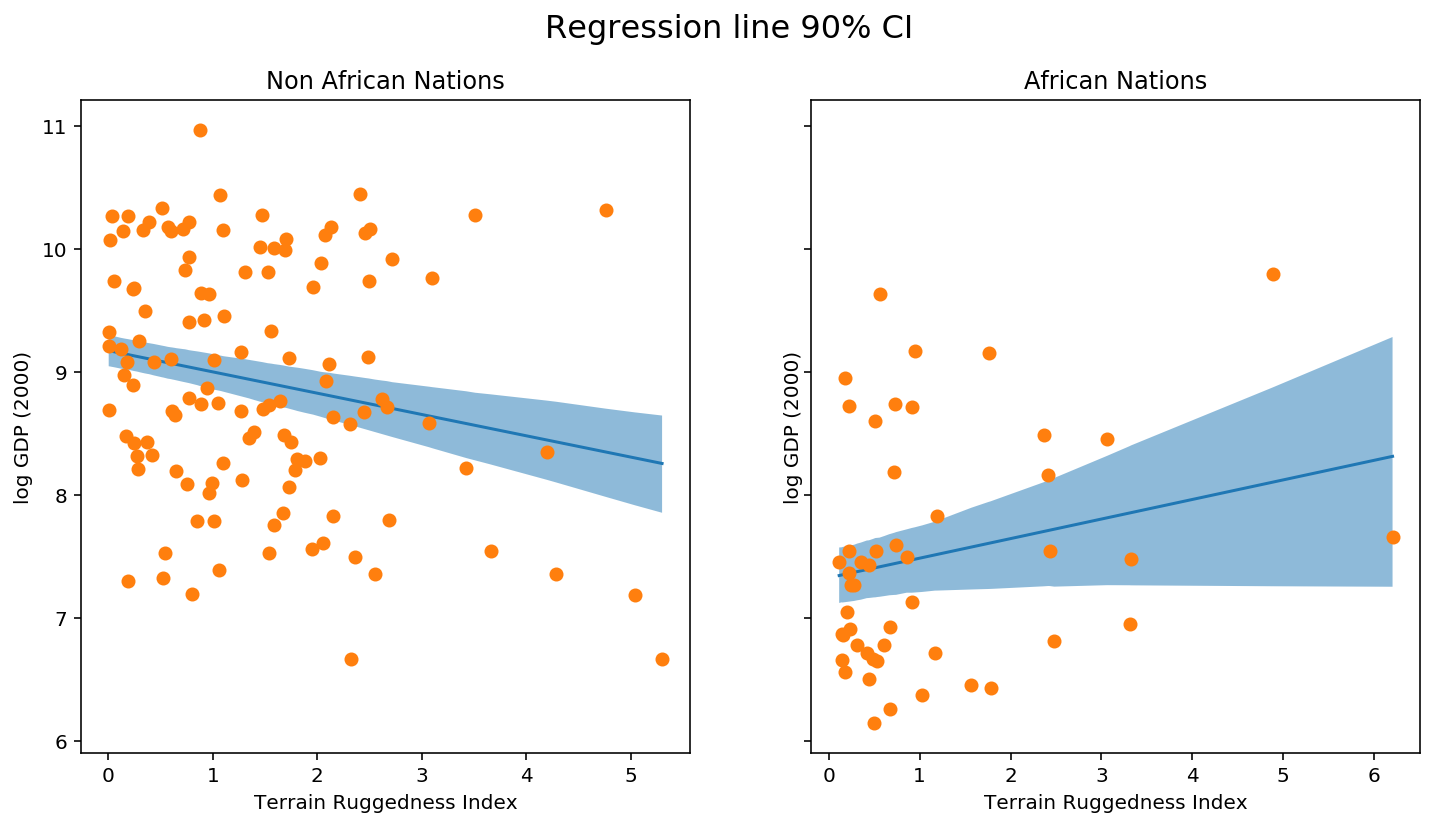

In [68]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
african_nations = predictions[predictions["cont_africa"] == 1]
non_african_nations = predictions[predictions["cont_africa"] == 0]
african_nations = african_nations.sort_values(by=["rugged"])
non_african_nations = non_african_nations.sort_values(by=["rugged"])
fig.suptitle("Regression line 90% CI", fontsize=16)
ax[0].plot(non_african_nations["rugged"],
           non_african_nations["mu_mean"])
ax[0].fill_between(non_african_nations["rugged"],
                   non_african_nations["mu_perc_5"],
                   non_african_nations["mu_perc_95"],
                   alpha=0.5)
ax[0].plot(non_african_nations["rugged"],
           non_african_nations["true_gdp"],
           "o")
ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="Non African Nations")
idx = np.argsort(african_nations["rugged"])
ax[1].plot(african_nations["rugged"],
           african_nations["mu_mean"])
ax[1].fill_between(african_nations["rugged"],
                   african_nations["mu_perc_5"],
                   african_nations["mu_perc_95"],
                   alpha=0.5)
ax[1].plot(african_nations["rugged"],
           african_nations["true_gdp"],
           "o")
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="African Nations");

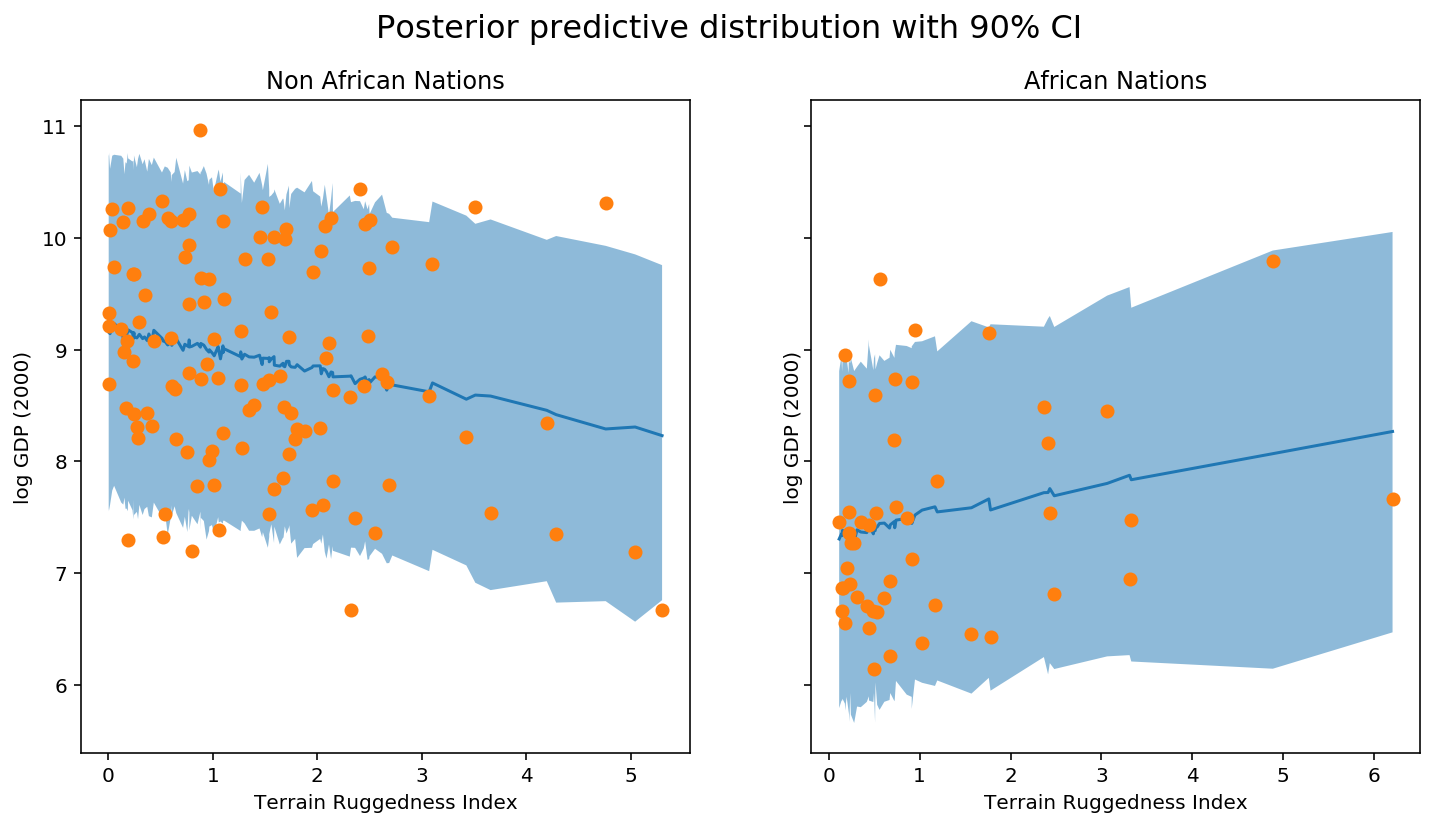

In [69]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
fig.suptitle("Posterior predictive distribution with 90% CI", fontsize=16)
ax[0].plot(non_african_nations["rugged"],
           non_african_nations["y_mean"])
ax[0].fill_between(non_african_nations["rugged"],
                   non_african_nations["y_perc_5"],
                   non_african_nations["y_perc_95"],
                   alpha=0.5)
ax[0].plot(non_african_nations["rugged"],
           non_african_nations["true_gdp"],
           "o")
ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="Non African Nations")
idx = np.argsort(african_nations["rugged"])

ax[1].plot(african_nations["rugged"],
           african_nations["y_mean"])
ax[1].fill_between(african_nations["rugged"],
                   african_nations["y_perc_5"],
                   african_nations["y_perc_95"],
                   alpha=0.5)
ax[1].plot(african_nations["rugged"],
           african_nations["true_gdp"],
           "o")
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="African Nations");

We can look at the distribution of slope of log GDP given terrain ruggedness for nations within and outside Africa.

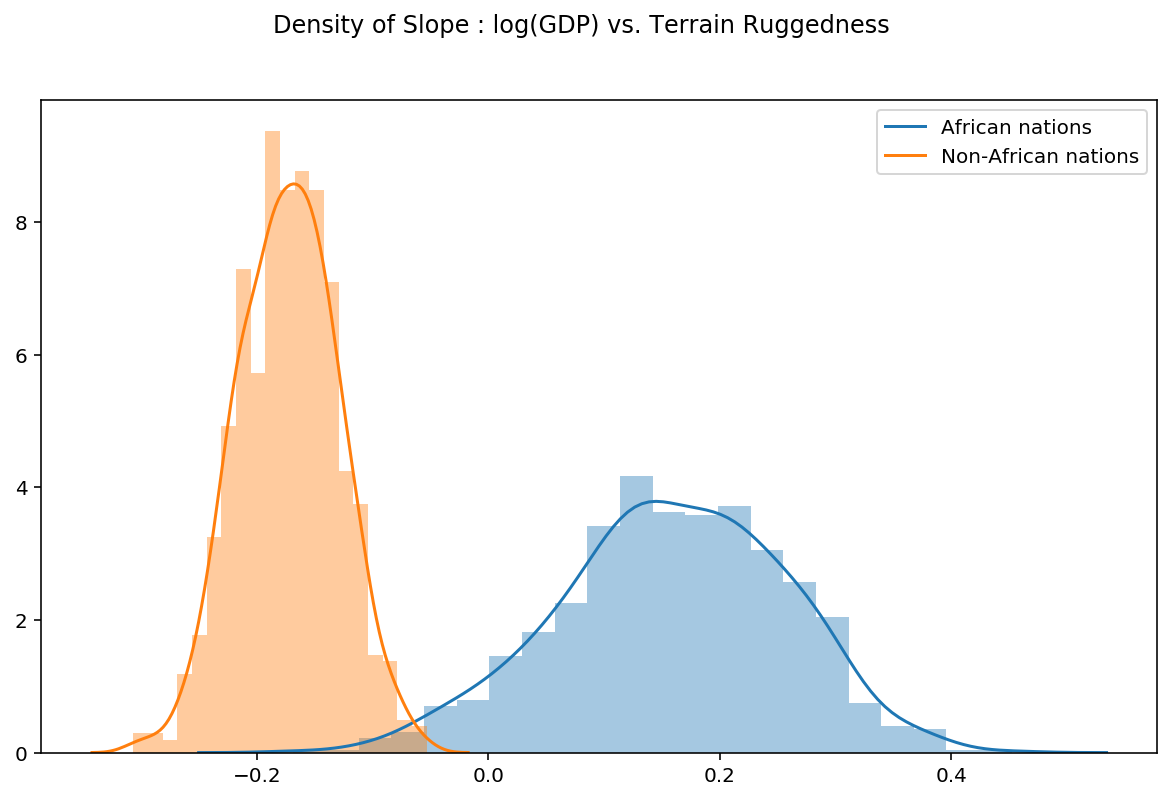

In [70]:
weight = samples["linear.weight"]
weight = weight.reshape(weight.shape[0], 3)
gamma_within_africa = weight[:, 1] + weight[:, 2]
gamma_outside_africa = weight[:, 1]
fig = plt.figure(figsize=(10, 6))
sns.distplot(gamma_within_africa, kde_kws={"label": "African nations"},)
sns.distplot(gamma_outside_africa, kde_kws={"label": "Non-African nations"})
fig.suptitle("Density of Slope : log(GDP) vs. Terrain Ruggedness");

## Gaussian Processes in Pyro

In [27]:
import os
import matplotlib.pyplot as plt
import torch

import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist

smoke_test = ('CI' in os.environ)  # ignore; used to check code integrity in the Pyro repo
assert pyro.__version__.startswith('1.2.1')
pyro.enable_validation(True)       # can help with debugging
pyro.set_rng_seed(0)

In [43]:
# note that this helper function does three different things:
# (i) plots the observed data;
# (ii) plots the predictions from the learned GP after conditioning on data;
# (iii) plots samples from the GP prior (with no conditioning on observed data)

def plot(plot_observed_data=False, plot_predictions=False, n_prior_samples=0,
         model=None, kernel=None, n_test=500):

    plt.figure(figsize=(8, 5))
    if plot_observed_data:
        plt.plot(X.numpy(), y.numpy(), 'kx')
    if plot_predictions:
        Xtest = torch.linspace(-0.5, 5.5, n_test)  # test inputs
        # compute predictive mean and variance
        with torch.no_grad():
            if type(model) == gp.models.VariationalSparseGP:
                mean, cov = model(Xtest, full_cov=True)
            else:
                mean, cov = model(Xtest, full_cov=True, noiseless=False)
        sd = cov.diag().sqrt()  # standard deviation at each input point x
        plt.plot(Xtest.numpy(), mean.numpy(), 'r', lw=2)  # plot the mean
        plt.fill_between(Xtest.numpy(),  # plot the two-sigma uncertainty about the mean
                         (mean - 2.0 * sd).numpy(),
                         (mean + 2.0 * sd).numpy(),
                         color='C0', alpha=0.3)
    if n_prior_samples > 0:  # plot samples from the GP prior
        Xtest = torch.linspace(-0.5, 5.5, n_test)  # test inputs
        noise = (model.noise if type(model) != gp.models.VariationalSparseGP
                 else model.likelihood.variance)
        cov = kernel.forward(Xtest) + noise.expand(n_test).diag()
        samples = dist.MultivariateNormal(torch.zeros(n_test), covariance_matrix=cov)\
                      .sample(sample_shape=(n_prior_samples,))
        plt.plot(Xtest.numpy(), samples.numpy().T, lw=2, alpha=0.4)

    plt.xlim(-0.5, 5.5)

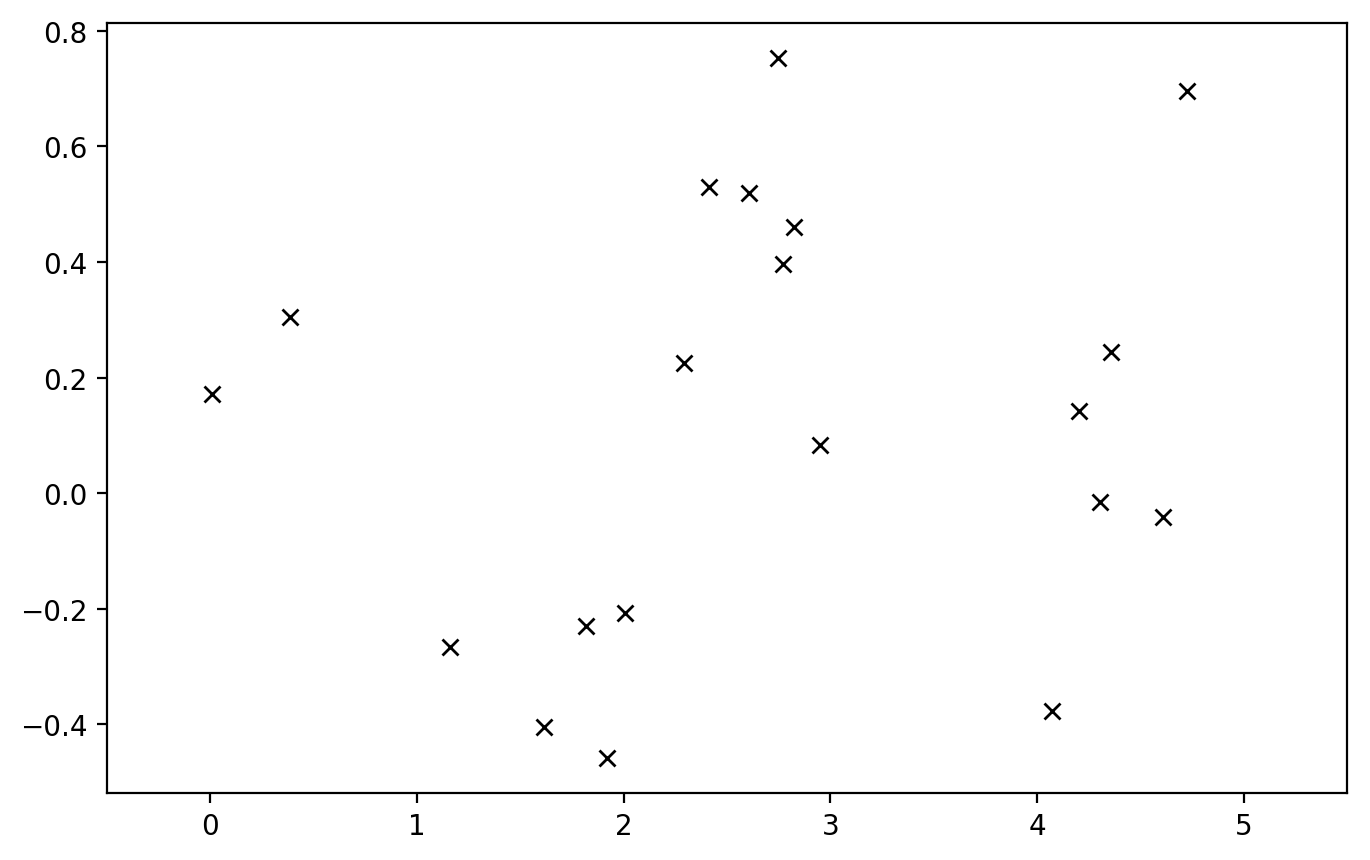

In [44]:
# data

N = 20
X = dist.Uniform(0.0, 5.0).sample(sample_shape=(N,))
y = 0.5 * torch.sin(3*X) + dist.Normal(0.0, 0.2).sample(sample_shape=(N,))

plot(plot_observed_data=True)  # let's plot the observed data

First we define a RBF kernel, specifying the values of the two hyperparameters `variance` and `lengthscale`. Then we construct a `GPRegression` object. Here we feed in another hyperparameter, noise.

In [45]:
kernel = gp.kernels.RBF(input_dim=1, variance=torch.tensor(5.),
                        lengthscale=torch.tensor(10.))
gpr = gp.models.GPRegression(X, y, kernel, noise=torch.tensor(1.))

Let’s see what samples from this GP function prior look like. Note that this is before we’ve conditioned on the data. The shape these functions take—their smoothness, their vertical scale, etc.—is controlled by the GP kernel.

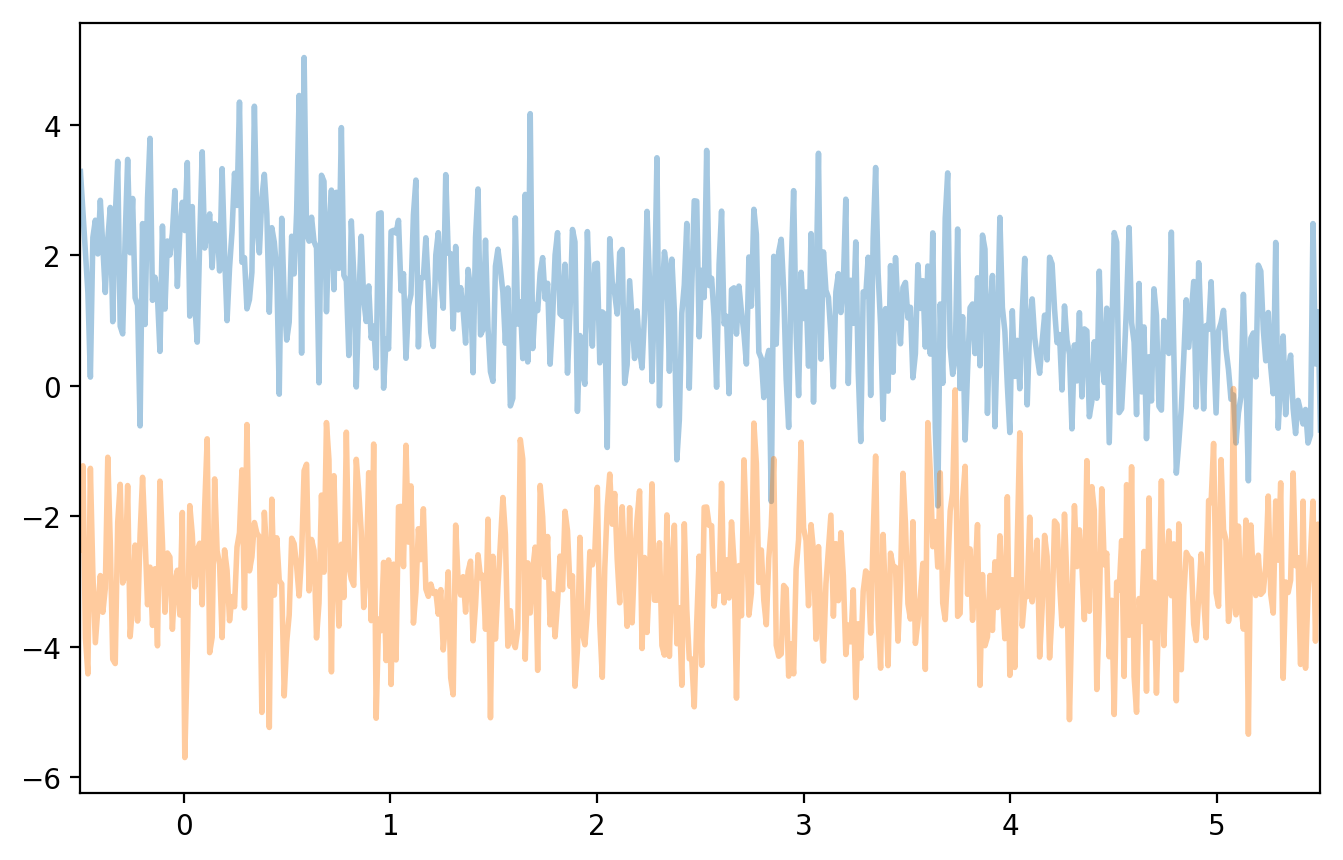

In [46]:
plot(model=gpr, kernel=kernel, n_prior_samples=2)

We can make the variance and noise smaller:

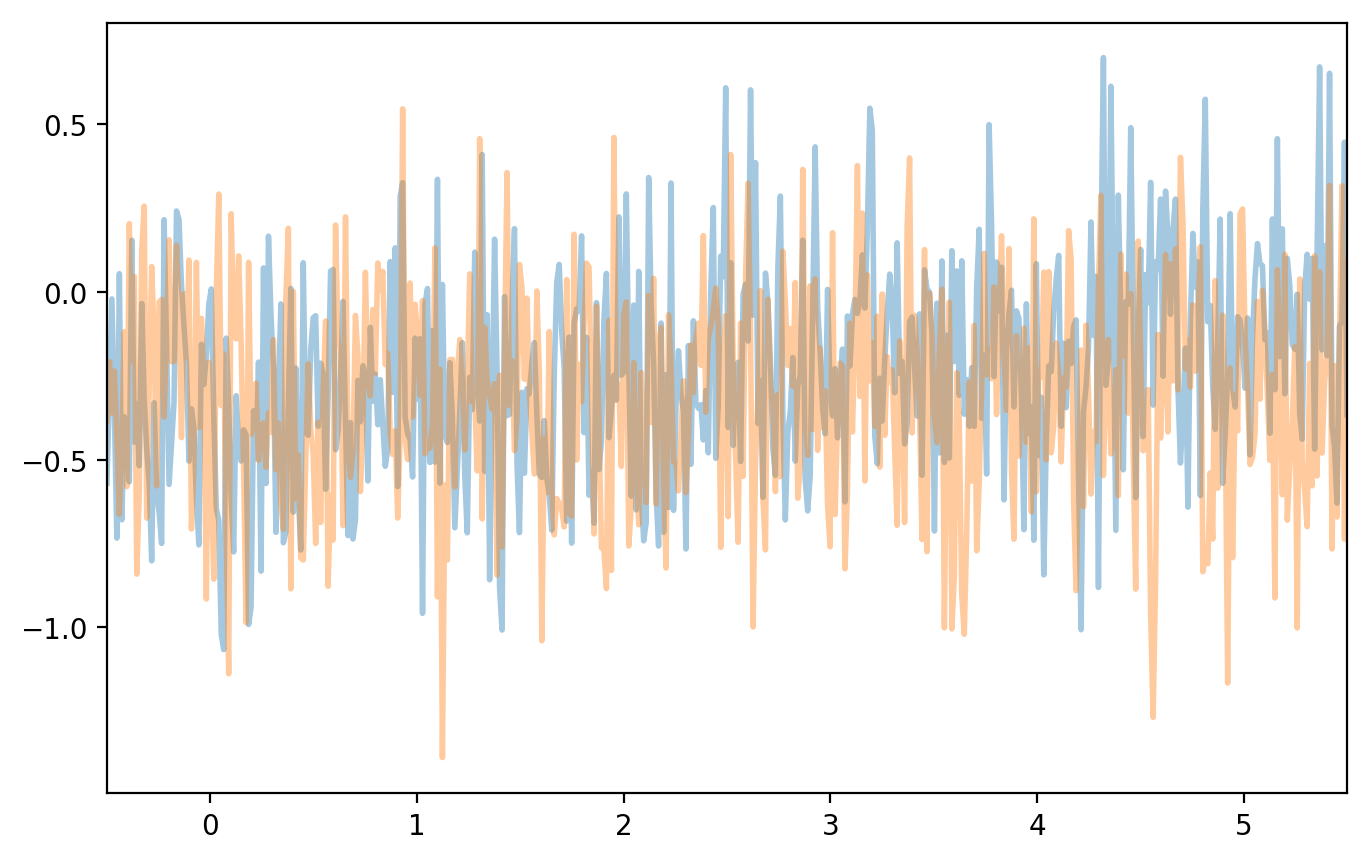

In [47]:
kernel2 = gp.kernels.RBF(input_dim=1, variance=torch.tensor(0.1),
                         lengthscale=torch.tensor(10.))
gpr2 = gp.models.GPRegression(X, y, kernel2, noise=torch.tensor(0.1))
plot(model=gpr2, kernel=kernel2, n_prior_samples=2)

### Fit the Model using MLE

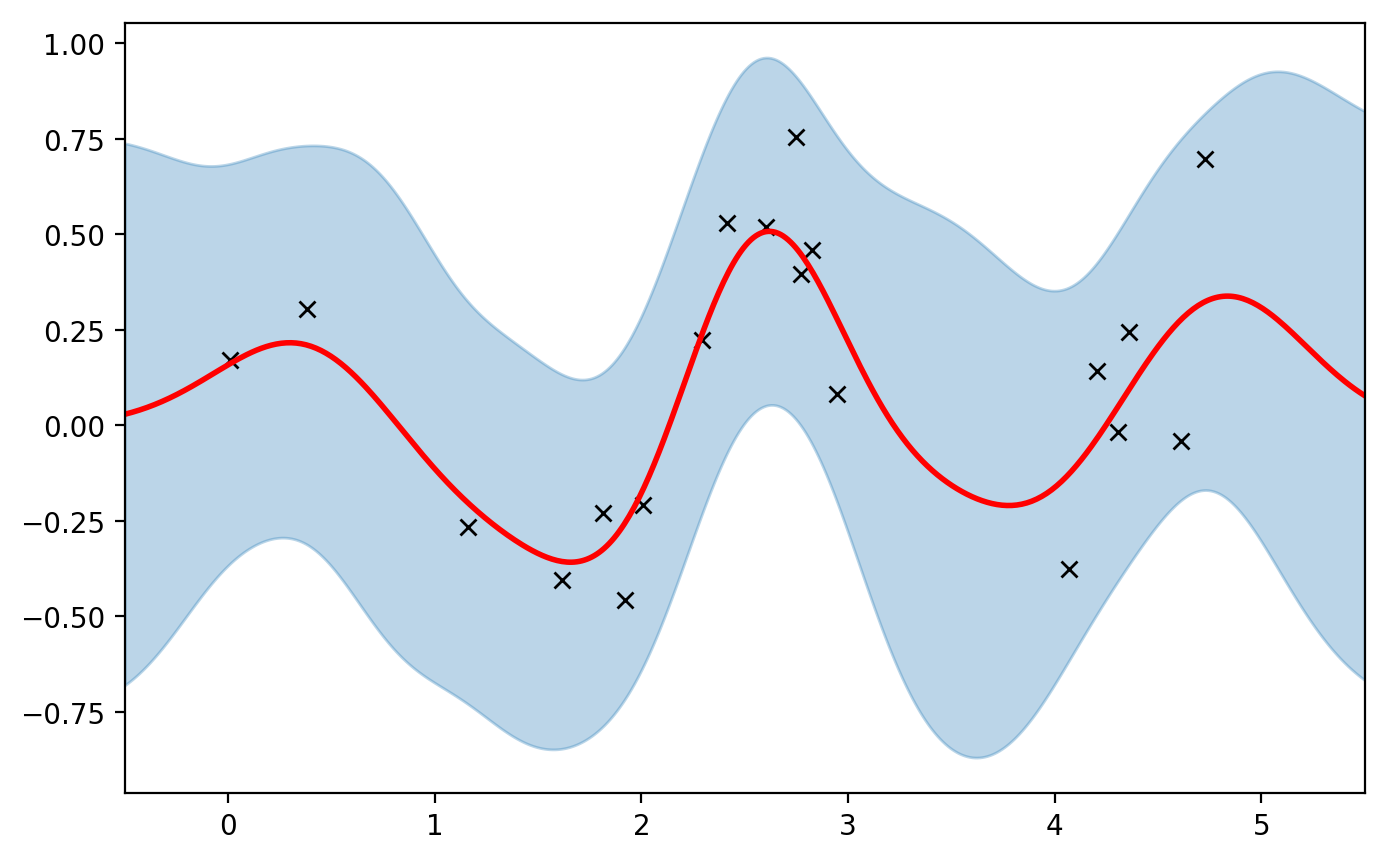

In [48]:
optimizer = torch.optim.Adam(gpr.parameters(), lr=0.005)
loss_fn = pyro.infer.Trace_ELBO().differentiable_loss
losses = []
num_steps = 2500 if not smoke_test else 2
for i in range(num_steps):
    optimizer.zero_grad()
    loss = loss_fn(gpr.model, gpr.guide)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    
plot(model=gpr, plot_observed_data=True, plot_predictions=True)

In [49]:
# tell gpr that we want to get samples from guides
gpr.set_mode('guide')
print('variance = {}'.format(gpr.kernel.variance))
print('lengthscale = {}'.format(gpr.kernel.lengthscale))
print('noise = {}'.format(gpr.noise))

variance = 0.09840446710586548
lengthscale = 0.4004512429237366
noise = 0.042222458869218826


### Fit the Model using MAP

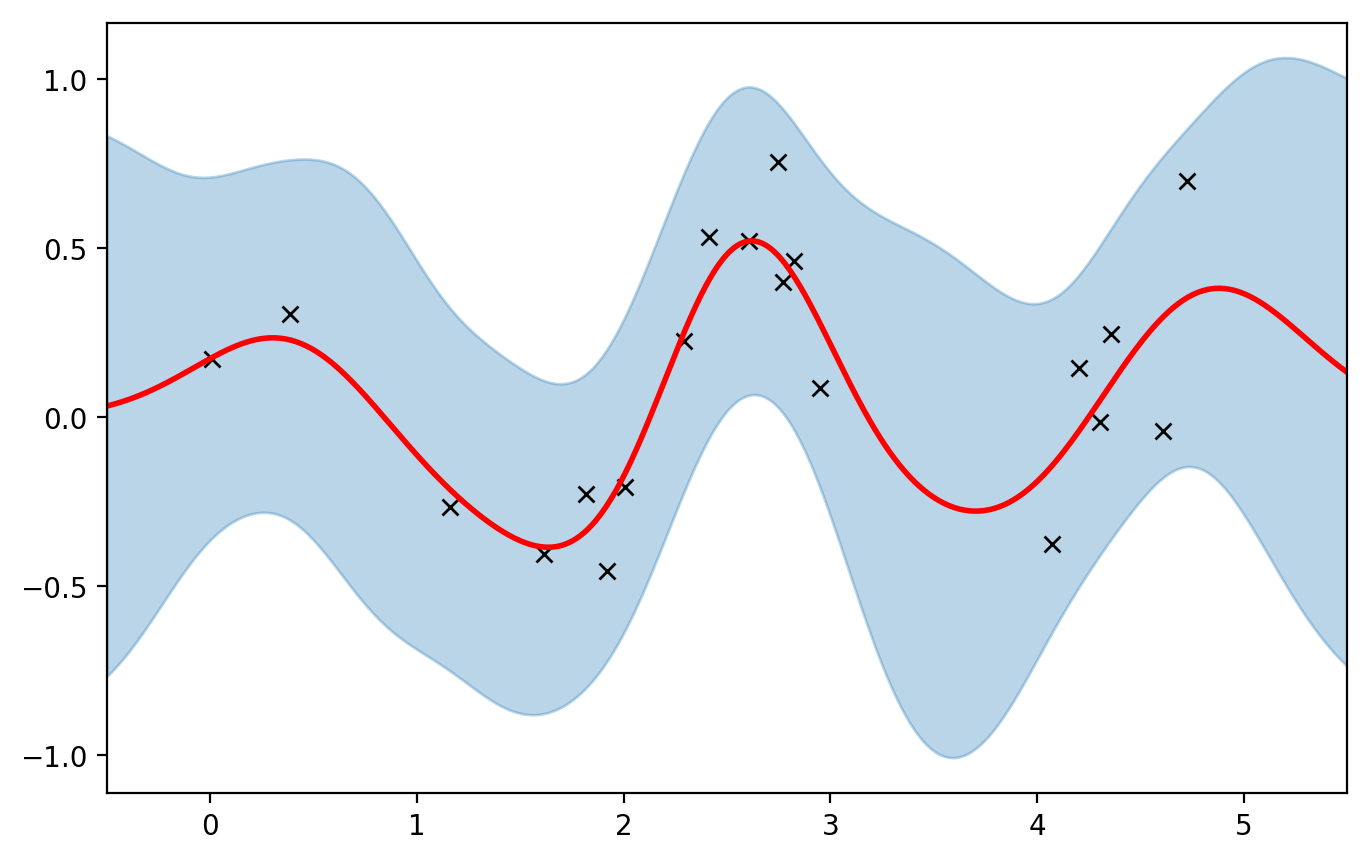

In [50]:
# Define the same model as before.
pyro.clear_param_store()
kernel = gp.kernels.RBF(input_dim=1, variance=torch.tensor(5.),
                        lengthscale=torch.tensor(10.))
gpr = gp.models.GPRegression(X, y, kernel, noise=torch.tensor(1.))

# note that our priors have support on the positive reals
gpr.kernel.lengthscale = pyro.nn.PyroSample(dist.LogNormal(0.0, 1.0))
gpr.kernel.variance = pyro.nn.PyroSample(dist.LogNormal(0.0, 1.0))

optimizer = torch.optim.Adam(gpr.parameters(), lr=0.005)
loss_fn = pyro.infer.Trace_ELBO().differentiable_loss
losses = []
num_steps = 2500 if not smoke_test else 2
for i in range(num_steps):
    optimizer.zero_grad()
    loss = loss_fn(gpr.model, gpr.guide)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
#plt.plot(losses);
plot(model=gpr, plot_observed_data=True, plot_predictions=True)

In [51]:
# tell gpr that we want to get samples from guides
gpr.set_mode('guide')
print('variance = {}'.format(gpr.kernel.variance))
print('lengthscale = {}'.format(gpr.kernel.lengthscale))
print('noise = {}'.format(gpr.noise))

variance = 0.15439076721668243
lengthscale = 0.4470186233520508
noise = 0.0422893725335598


Note that the MAP values are different from the MLE values due to the prior.

## Resources
- http://www.gaussianprocess.org/gpml/chapters/RW.pdf
- http://www.greenteapress.com/thinkbayes/thinkbayes.pdf
- https://pyro.ai/examples/bayesian_regression.html#Linear-Regression